# Trénovanie modelu na základe DST indexu, F10_indexu a BZ_GSM 6h dopredu 6 dozadu
Súbor: 6_6_pridane_atr.ipynb

Program: Hospodárska informatika

Vypracovala: Bc. Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 21.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 25.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard

### Kontrola kapacity servera

In [2]:
!nvidia-smi

Mon Mar 13 21:23:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:8B:00.0 Off |                  N/A |
| 30%   41C    P0    39W / 125W |    912MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
           'DST',
            'F10_INDEX',
            'BZ_GSM',
            'DST+6']
test = test[features]
train = train[features]
train = train.dropna()
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST+6'
predicators = ['DST',
            'F10_INDEX',
            'BZ_GSM']

y_col='DST+6'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [18]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train[['DST','BZ_GSE','F10_INDEX']].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid[['DST','BZ_GSE','F10_INDEX']].values.copy()

y_test = test[y_col].values.copy()
X_test = test[['DST','BZ_GSE','F10_INDEX']].values.copy()

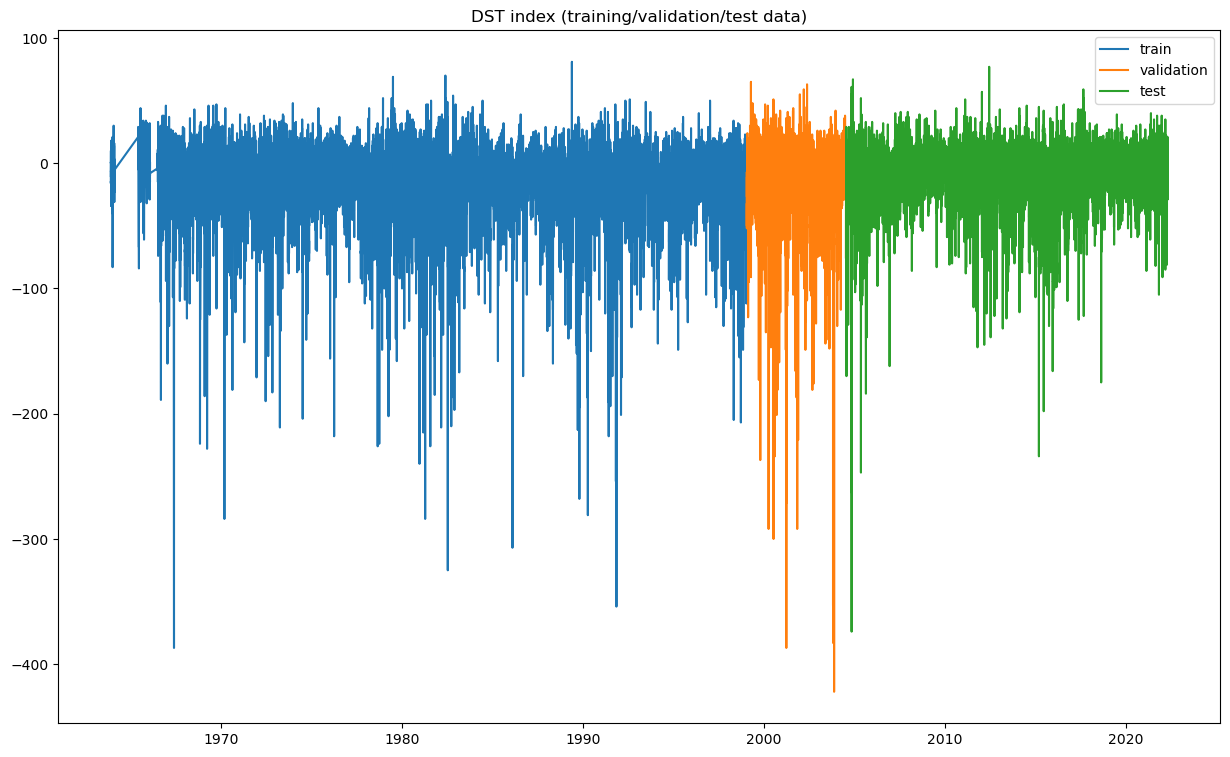

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST+6'],label='train')
plt.plot(valid['time1'],valid['DST+6'],label='validation')
plt.plot(test['time1'],test['DST+6'],label='test')
plt.legend();

In [6]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [7]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  753
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [8]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional((LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True, dropout=0.1,recurrent_dropout=0.1)))(inputs)
c = LSTM(128, input_shape=(X_train.shape[0], X_train.shape[1]), return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2023-03-13 21:23:51.869561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5765 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:8b:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           135168    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [29]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              135168    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                           

In [88]:
inputs = Input(shape=(6,3)) #(kolko hodinove je okno, kolko je features v train)
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(3, activation='linear'))(c)
output = Flatten()(c)
output = Dense(3, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 6, 256)           135168    
 nal)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 6, 128)            197120    
                                                                 
 time_distributed_3 (TimeDis  (None, 6, 3)             387       
 tributed)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 18)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 57  

In [9]:
# callbacks
saved_model = "6_6_pridane_atr.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [10]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20


2023-03-13 21:24:03.516598: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


753/753 [==============================] - ETA: 0s - loss: 143.5550 - mae: 5.5012
Epoch 1: val_mae improved from inf to 5.11032, saving model to 6_6_pridane_atr.hdf5
753/753 [==============================] - 52s 60ms/step - loss: 143.5550 - mae: 5.5012 - val_loss: 122.4680 - val_mae: 5.1103
Epoch 2/20
753/753 [==============================] - ETA: 0s - loss: 61.7670 - mae: 3.9449
Epoch 2: val_mae improved from 5.11032 to 3.67367, saving model to 6_6_pridane_atr.hdf5
753/753 [==============================] - 45s 60ms/step - loss: 61.7670 - mae: 3.9449 - val_loss: 70.1379 - val_mae: 3.6737
Epoch 3/20
753/753 [==============================] - ETA: 0s - loss: 48.9002 - mae: 3.5467
Epoch 3: val_mae improved from 3.67367 to 2.83878, saving model to 6_6_pridane_atr.hdf5
753/753 [==============================] - 45s 60ms/step - loss: 48.9002 - mae: 3.5467 - val_loss: 50.4985 - val_mae: 2.8388
Epoch 4/20
753/753 [==============================] - ETA: 0s - loss: 48.5804 - mae: 3.5235
Epoch

In [12]:
# load best model
model = keras.models.load_model('6_6_pridane_atr.hdf5')

In [13]:
# prediction
y_pred = model.predict(test_generator)

607/607 [==============================] - 10s 14ms/step


In [14]:
y_pred

array([[ 12.397661],
       [ 16.067488],
       [ 17.92329 ],
       ...,
       [-15.423409],
       [-19.208242],
       [-22.71293 ]], dtype=float32)

In [15]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124416    226]
 [  3321  27290]]


In [16]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    124642
           1       0.99      0.89      0.94     30611

    accuracy                           0.98    155253
   macro avg       0.98      0.94      0.96    155253
weighted avg       0.98      0.98      0.98    155253



In [17]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [18]:
df

,time,y_true,y_predict
6,2004-07-22 04:00:00,10.0,12.397661
7,2004-07-22 05:00:00,13.0,16.067488
8,2004-07-22 06:00:00,16.0,17.923290
9,2004-07-22 07:00:00,14.0,15.516572
10,2004-07-22 08:00:00,14.0,15.105329
...,...,...,...
155254,2022-04-28 20:00:00,-15.0,-15.592626
155255,2022-04-28 21:00:00,-15.0,-15.801143
155256,2022-04-28 22:00:00,-13.0,-15.423409
155257,2022-04-28 23:00:00,-18.0,-19.208242


In [19]:
df.describe()

,y_true,y_predict
count,155253.000000,155253.000000
mean,-9.816706,-9.400855
std,16.339614,15.091578
min,-374.000000,-209.977310
25%,-16.000000,-16.187973
50%,-7.000000,-7.600258
75%,0.000000,0.240278
max,77.000000,36.821243


<AxesSubplot: >

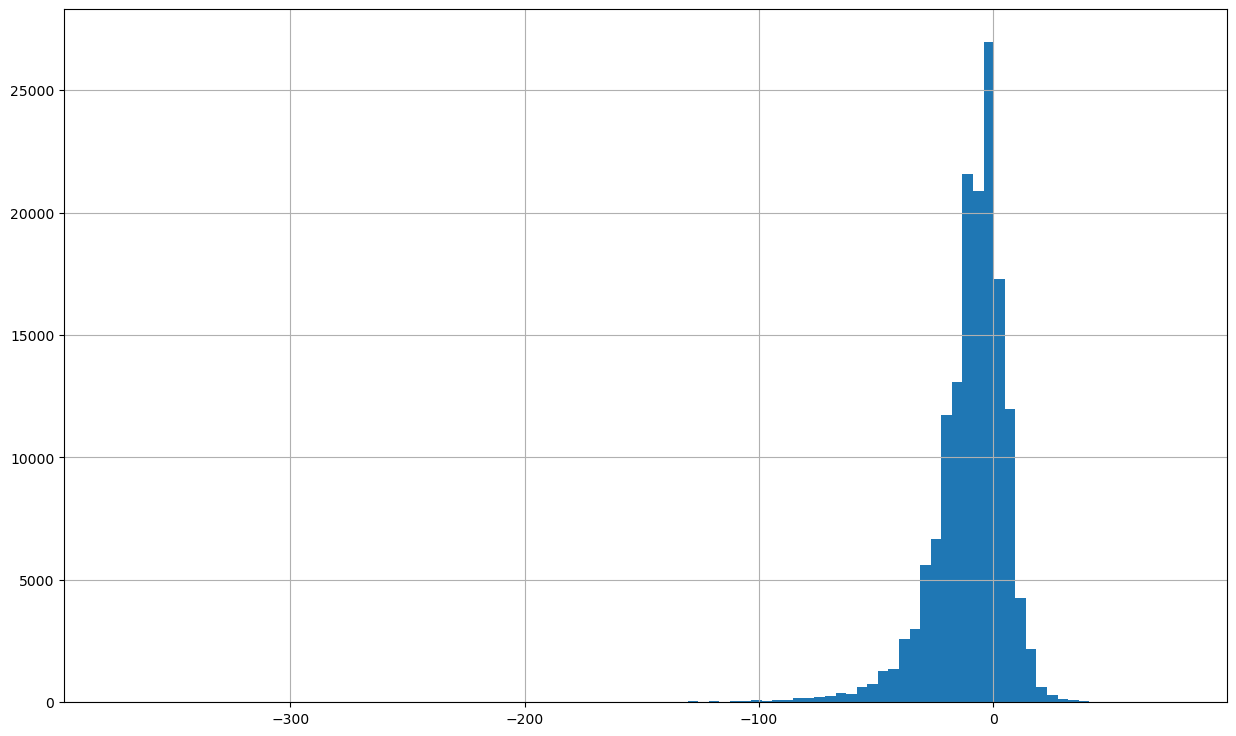

In [20]:
df["y_true"].hist(bins=100)

<AxesSubplot: >

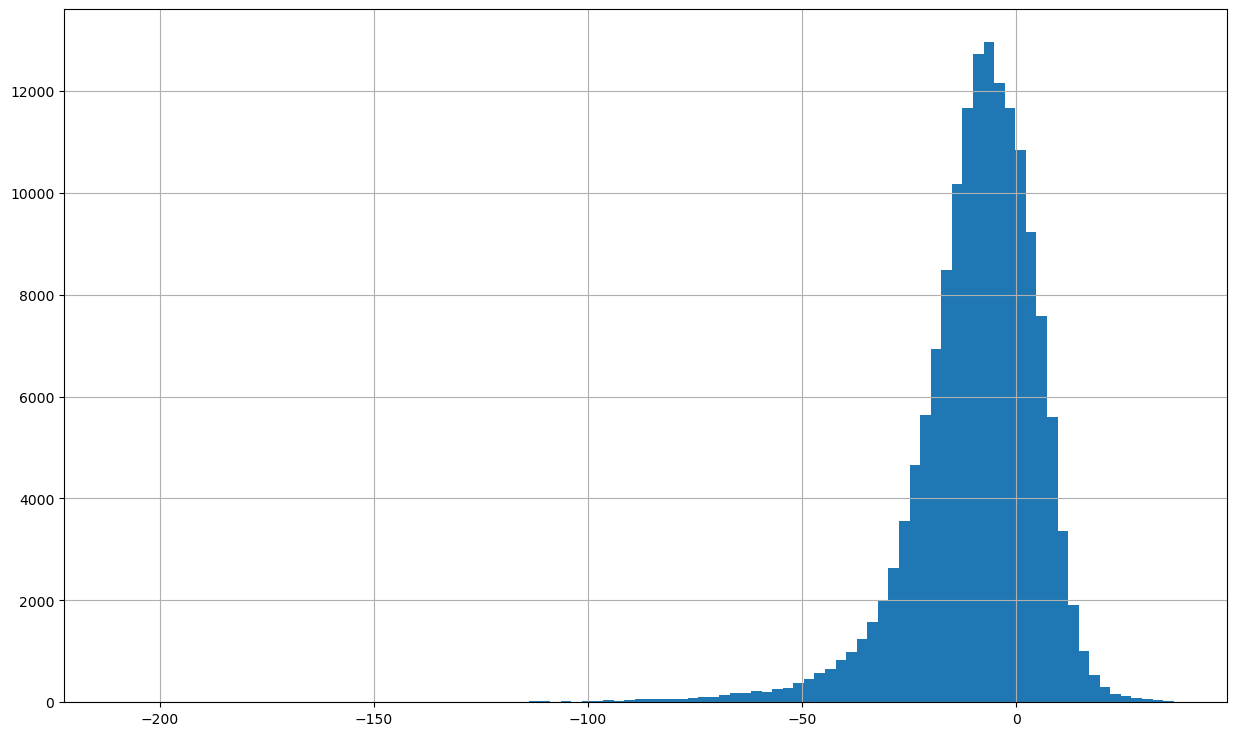

In [21]:
df["y_predict"].hist(bins=100)

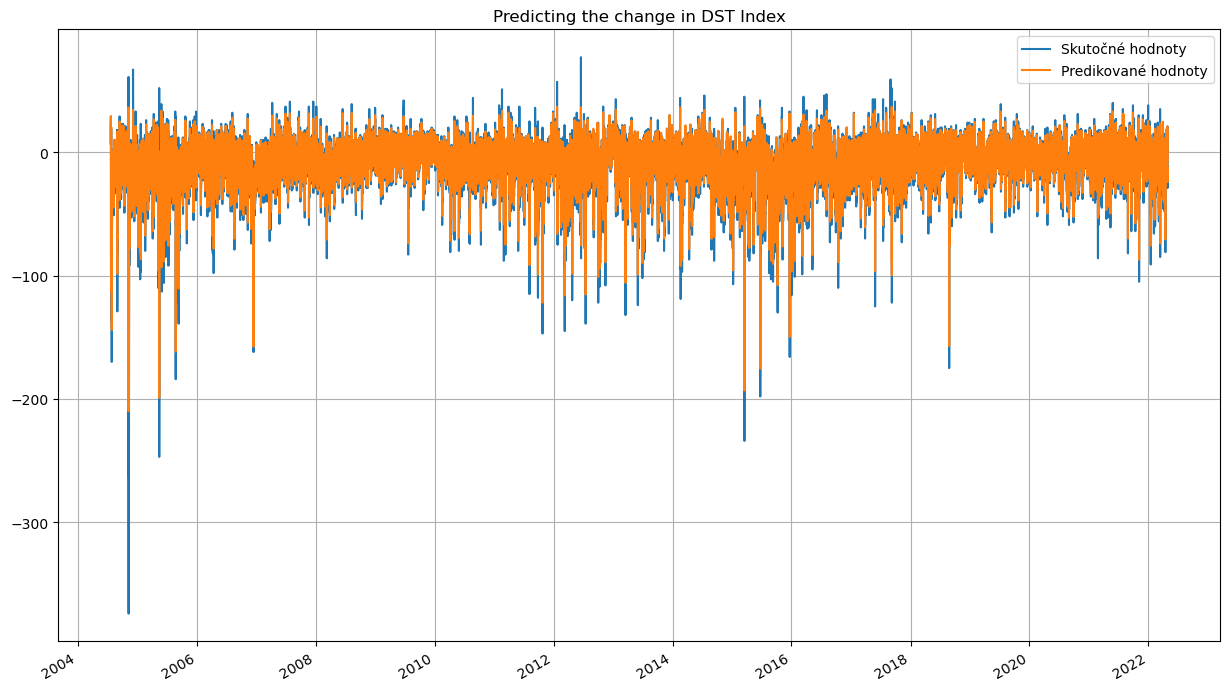

In [22]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [23]:
df.to_csv('predikcie_6_6_prid_atr.csv')

In [24]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[124416    226]
 [  3321  27290]]


In [25]:
TN = cm[0,0] 
print(TN)
FP = cm[0,1]
print(FP)
FN = cm[1,0] 
print(FN)
TP = cm[1,1] 
print(TP)

124416
226
3321
27290


In [26]:
from sklearn.metrics import *
TN = cm[0,0] 
print("TN={}".format(TN))
FP = cm[0,1]
print("FP={}".format(FP))
FN = cm[1,0] 
print("FN={}".format(FN))
TP = cm[1,1] 
print("TP={}".format(TP))
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR={}".format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP)
print("TNR={}".format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV={}".format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV={}".format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR={}".format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print("FNR={}".format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR={}".format(FDR))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC={}".format(ACC))
fpr, tpr, threshold = roc_curve(y_test2, y_pred2)
AUC = auc(fpr, tpr)
print("AUC={}".format(AUC))
MCC = matthews_corrcoef(y_test2, y_pred2)
print("MCC={}".format(MCC))

TN=124416
FP=226
FN=3321
TP=27290
TPR=0.891509588056581
TNR=0.9981868070152918
PPV=0.9917865968890827
NPV=0.974001268230818
FPR=0.0018131929847082042
FNR=0.10849041194341903
FDR=0.008213403110917285
ACC=0.9771534205458188
AUC=0.9448481975359364
MCC=0.9269616939233981
